# Exercise 1

**Task:** *Tune the hyperparameters of the training to beat my best validation loss of 2.2.*

In [1]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import notebook

RANDOM_SEED = 42
BENCHMARK_DEV_LOSS = 2.2

sns.set_theme()

## Data preparation

We will firstly read the file with names into a variable and after that will prepare the data as before.

In [2]:
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

In [4]:
char2id

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [5]:
id2char

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Creating training, dev and test sets

Next, let's define which examples with appear in the training, development and test sets. The words will first be reshuffled and after words we will define the cutoff points for sets.

In [6]:
len(words)

32033

In [7]:
# Setting the random seed and reshuffling names
random.seed(RANDOM_SEED)
random.shuffle(words)

# Determining cutoff points for 10% dev and 10% test
cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032


Now, using cutoffs we will redistribute examples into three distinct sets. 

In [8]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


Now that we have training, development and testing words ready, we should encode each set. This will be done by `build_dataset` function that will take a list of names to encode as well as the block size as inputs in order to produce the dataset. For instance, for `block_size=3` we will be using three letters to predict the fourth one. The function is written in such a way that we can flexibly select block size in order to generate the dataset is we, for instance, want to experiment with other amounts of letters.

In [9]:
def build_dataset(words, block_size):
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # Reshaping if using bigram model
    if block_size == 1:
        X = X.view(-1)
    
    return X, Y

In [10]:
# Building the datasets for three sets
X_train, Y_train = build_dataset(
    words=words_train, block_size=3,
)
X_dev, Y_dev = build_dataset(
    words=words_dev, block_size=3,
)
X_test, Y_test = build_dataset(
    words=words_test, block_size=3,
)

Now, let's take a look at the datasets created:

In [11]:
# Training set
X_train, Y_train

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         ...,
         [15, 12,  4],
         [12,  4,  1],
         [ 4,  1, 14]]),
 tensor([25, 21,  8,  ...,  1, 14,  0]))

In [12]:
# Dev set
X_dev, Y_dev

(tensor([[ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 13],
         ...,
         [ 8,  1, 25],
         [ 1, 25, 12],
         [25, 12,  1]]),
 tensor([ 1, 13,  1,  ..., 12,  1,  0]))

In [13]:
# Test set
X_test, Y_test

(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13, 21],
         ...,
         [15, 22,  1],
         [22,  1, 14],
         [ 1, 14,  9]]),
 tensor([13, 21, 19,  ..., 14,  9,  0]))

## Creating the Multilayer Perceptron (MLP)

We can now replicate the Neural Network design as described in *Bengio et al (2003)* which will be packaged inside the `MLP` class. One difference though is that we will be using character-level model rather than word-based one.

In [14]:
class MLP:
    def __init__(
        self, 
        emb_dim_1,
        emb_dim_2,
        l1_out_features,
        l2_out_features,
        num_epochs, 
        learning_rate, 
        block_size=3, 
        minibatch_size=32,
        loss_update_steps=1000,
        display_train_loss=True,
        seed=2147483647,
    ):
        """Constructor for MLP class."""
        # Creating class attributes
        self.emb_dim_1 = emb_dim_1
        self.emb_dim_2 = emb_dim_2
        self.l1_out_features = l1_out_features
        self.l2_out_features = l2_out_features
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.block_size = block_size
        self.minibatch_size = minibatch_size
        self.loss_update_steps = loss_update_steps
        self.display_train_loss = display_train_loss
        self.seed = seed
        
        # NN weights
        # Setting up a random number generator for reproducibility
        generator = torch.Generator().manual_seed(self.seed)
        # Generating a matrix of letter embeddings
        self.C = torch.randn((self.emb_dim_1, self.emb_dim_2), generator=generator)
        # Generating weights and biases for Layer 1
        self.W1 = torch.randn((self.block_size * self.emb_dim_2, self.l1_out_features), generator=generator)
        self.b1 = torch.randn(self.l1_out_features, generator=generator)
        # Generating weights and biases for Layer 2
        self.W2 = torch.randn((self.l1_out_features, self.l2_out_features), generator=generator)
        self.b2 = torch.randn(self.l2_out_features, generator=generator)
        # Putting all parameters together
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        # Computing the total number of trainable parameters
        self.num_params = sum(p.nelement() for p in self.parameters)
        
        # Enabling gradient updating for all weight matrices
        for p in self.parameters:
            p.requires_grad = True
        
    def __call__(self, x, y):
        """Makes a forward pass and computes the loss."""
        # Retrieving letter embeddings
        embeddings = self.C[x]
        # Passing Layer 1 + Activation (Tanh)
        layer1_out = torch.tanh(
            embeddings.view(
                -1, embeddings.shape[-2] * embeddings.shape[-1]
            ) @ self.W1 + self.b1
        )
        # Passing Layer 2
        logits = layer1_out @ self.W2 + self.b2
        # Activating the Layer 2 neurons + computing NLL loss
        loss = F.cross_entropy(logits, y)
        
        return loss     
    
    def fit(self, x, y):
        """Runs Stochactic Gradient Descent."""
        # Preallocating a dict for storing loss across epochs
        loss_per_epoch = {}
        # Defining a progress bar
        epoch_counter = notebook.tqdm(range(self.num_epochs))
        
        for k in epoch_counter:
            # Retrieving minibatch indices
            ix = torch.randint(0, x.shape[0], (self.minibatch_size,))
            # Computing loss
            loss = self(x[ix], y[ix])
            
            # Adding training loss to tqdm progress bar
            if self.display_train_loss and ((k % self.loss_update_steps == 0) or (k == self.num_epochs-1)):
                epoch_counter.set_postfix({"train_loss": loss.item()})
            
            # Adding a loss computed to the history
            loss_per_epoch[f"epoch_{k+1}"] = loss.item()
            
            # Setting all gradients for all matrices to zero
            for p in self.parameters:
                p.grad = None
            # Making a backward pass (backpropagation)
            loss.backward()
            
            # Updating weights (SGD)
            for p in self.parameters:
                p.data -= self.learning_rate * p.grad
        
        # Creating an attribute for training history after training
        self.history = loss_per_epoch
    
    @property
    def loss_function(self):
        """Plots the loss function against epochs."""
        # Verifying the accessibility of the attribute
        if not hasattr(self, "history"):
            # Raising error with a message
            rte_msg = (
            "MLP class does not yet have data about the loss. "
            "Run 'fit' method first."
            )
            raise RuntimeError(rte_msg)
        # Plotting the loss function
        loss_info = pd.Series(self.history.values())
        loss_info.plot()
        plt.xlabel("Epochs")
        plt.ylabel("NLL loss")
        plt.title("Loss evolution")
        plt.tight_layout()
        plt.show()
        
    def tune_learning_rate(self, x, y, lower_exp=-3, upper_exp=0):
        """Runs changing learning rate experiment."""
        # Defining exponents and actual learning rates
        lr_exponents = torch.linspace(lower_exp, upper_exp, self.num_epochs)
        lrs = 10**lr_exponents
        
        # Preallocating lists for storing information during LR tuning
        learning_rates_exponents = []
        losses = []
        
        # Defining a progress bar
        epoch_counter = notebook.tqdm(range(self.num_epochs))
        
        for k in epoch_counter:
            # Retrieving minibatch indices
            ix = torch.randint(0, x.shape[0], (self.minibatch_size,))
            # Computing loss
            loss = self(x[ix], y[ix])
            
            # Setting all gradients for all matrices to zero
            for p in self.parameters:
                p.grad = None
            # Making a backward pass (backpropagation)
            loss.backward()
            
            # Updating weights (while varying learning rates)
            learning_rate = lrs[k]
            for p in self.parameters:
                p.data -= learning_rate * p.grad
            # Adding 
            learning_rates_exponents.append(lr_exponents[k])
            losses.append(loss.item())
        
        # Plotting after tuning
        plt.plot(learning_rates_exponents, losses)
        plt.xlabel("LR exponent")
        plt.ylabel("NLL loss")
        plt.title("Tuning learning_rate")
        plt.tight_layout()
        plt.show()
            
    def generate_sample(self, num_examples, id2char):
        """Generates a number of names."""
        generator = torch.Generator().manual_seed(self.seed)
        # Preallocating a list for storing generated names
        generated_names = []
        for _ in range(num_examples):
            # Preallocating a list for storing letters
            out = []
            # Initializing generation with "..." ([0, 0, 0] for block_size=3)
            context = [0] * self.block_size
            while True:
                # Retieving embeddings
                embeddings = self.C[torch.tensor([context])]
                # Layer 1
                layer1_out = torch.tanh(embeddings.view(1, -1) @ self.W1 + self.b1)
                # Layer 2
                logits = layer1_out @ self.W2 + self.b2
                # Activation for Layer 2 (Softmax)
                probas = F.softmax(logits, dim=1)
                
                ix = torch.multinomial(probas, num_samples=1, generator=generator).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break

            generated_names.append(''.join(id2char[i] for i in out)[:-1])
        
        return generated_names

## Tuning learning rate

Firstly, we will find the optimal learning rate that we can use for model training. For now, we will define `learning_rate=None` and will provide all other required arguments to initialize the object of the class.

In [15]:
# Instantiating a MLP model
mlp_model = MLP(
    emb_dim_1=27,
    emb_dim_2=10,
    l1_out_features=200, 
    l2_out_features=27,
    num_epochs=1000,
    learning_rate=None,
)

print(f"Number of parameters: {mlp_model.num_params:,}")

Number of parameters: 11,897


Basically, we decided to use matrix $C$ of letter embeddings of size $27 \times 10$. The first dimension refers to the amount of letters + 1 special token we have which we want to map into a 10-dimensional space. Secondly, after making the first forward pass we end up in the hidden layer of 200 neurons from where we then making a second forward pass thus reaching 27 output neurons for each letter.

We can now use `tune_learning_rate` method we created in order to obtain a plot showing optimal learning rates we can try.

  0%|          | 0/1000 [00:00<?, ?it/s]

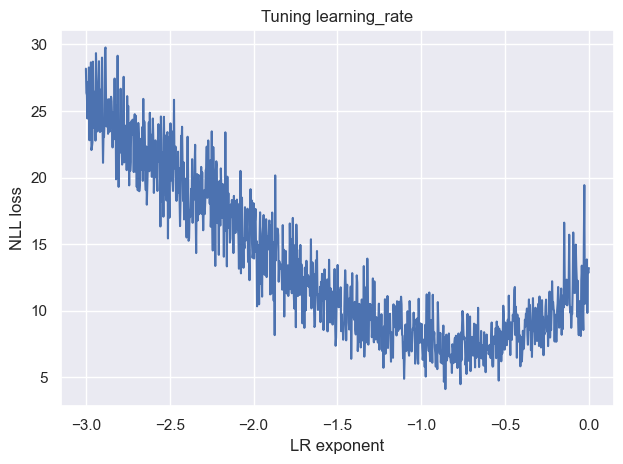

In [16]:
# Launching LR tuning
mlp_model.tune_learning_rate(X_train, Y_train)

## First training

It is seen here that the optimal learning rate lies somewhere between $10^{-1}$ and $10^{-0.5}$. We will try to use the latter. Now, we will again instantiate the class object with `learning_rate=0.1` added. We will run the model for $100000$ iterations.

In [17]:
mlp_model = MLP(
    emb_dim_1=27,
    emb_dim_2=10,
    l1_out_features=200,
    l2_out_features=27,
    num_epochs=100000,
    learning_rate=1e-1,
)

print(f"Number of parameters: {mlp_model.num_params:,}")

Number of parameters: 11,897


Training can be launched by using `fit` method that will provide a progress bar allowing us to keep track of not only the time of training left but also the training loss.

In [18]:
mlp_model.fit(X_train, Y_train)

  0%|          | 0/100000 [00:00<?, ?it/s]

Now that the training has been completed, we can look at what the loss function looks like by accessing `loss_function` attribute.

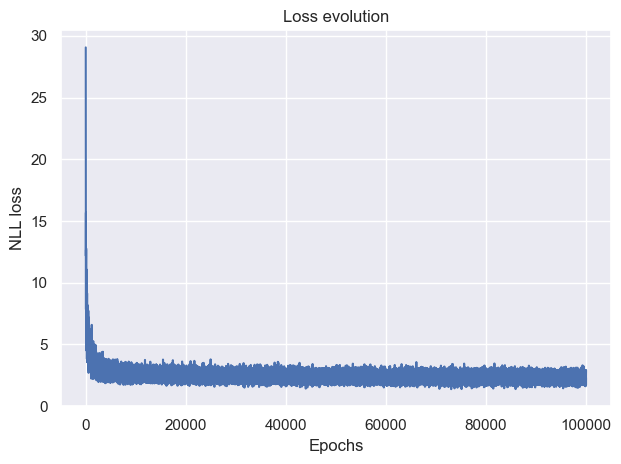

In [19]:
mlp_model.loss_function

Notably, we can see that already after, say, 3000 iterations the training loss plateaued without any considerable changes. It can also be noted that the loss function appears to be very noisy which happens due to using minibatches while training that create a lot of noise.

Let's look at training and dev loss:

In [20]:
train_loss = mlp_model(X_train, Y_train).item()
dev_loss = mlp_model(X_dev, Y_dev).item()

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss: {dev_loss:.4f}")

Train loss: 2.3043
Dev loss: 2.3436


It is seen here that the model does not suffer too much from overfitting. Nevertheless, we are still to improve the model to achieve the dev loss of less than 2.2.

## Improving the model

At this stage we will be running additional training loops in order to see if the dev loss is improving.

In [21]:
mlp_model.fit(X_train, Y_train)

train_loss = mlp_model(X_train, Y_train).item()
dev_loss = mlp_model(X_dev, Y_dev).item()

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss: {dev_loss:.4f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Train loss: 2.2583
Dev loss: 2.3145


We notice that the degree of overfitting slightly increased so let's continue one more time.

In [22]:
mlp_model.fit(X_train, Y_train)

train_loss = mlp_model(X_train, Y_train).item()
dev_loss = mlp_model(X_dev, Y_dev).item()

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss: {dev_loss:.4f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Train loss: 2.2188
Dev loss: 2.2865


What we can now do is to make use of the weight decay where we decrease the learning rate by, say, 10. Let's see what it will lead to:

In [23]:
# Weight decay
mlp_model.learning_rate = 0.01

mlp_model.fit(X_train, Y_train)
train_loss = mlp_model(X_train, Y_train).item()
dev_loss = mlp_model(X_dev, Y_dev).item()

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss: {dev_loss:.4f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Train loss: 2.0668
Dev loss: 2.1349


It can be seen that we have managed to further improve the dev loss. Let's run the model one more time before registering the final loss.

In [24]:
mlp_model.fit(X_train, Y_train)

train_loss = mlp_model(X_train, Y_train).item()
dev_loss = mlp_model(X_dev, Y_dev).item()

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss: {dev_loss:.4f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Train loss: 2.0572
Dev loss: 2.1260


## Evaluating the model

In [25]:
dev_loss = mlp_model(X_dev, Y_dev).item()
print(f"Dev loss: {dev_loss:.4f}")

assert dev_loss < BENCHMARK_DEV_LOSS

Dev loss: 2.1260


In [26]:
test_loss = mlp_model(X_test, Y_test).item()
print(f"Test loss: {test_loss:.4f}")

Test loss: 2.1240


In [27]:
mlp_model.generate_sample(num_examples=100, id2char=id2char)

['dexze',
 'zomanuelice',
 'kayden',
 'maimitta',
 'nylandrika',
 'dakshaivaugutthamilton',
 'moriella',
 'kinzo',
 'mda',
 'kaley',
 'maside',
 'ankavion',
 'hatlan',
 'huniven',
 'tahlan',
 'kashri',
 'anell',
 'pennaisa',
 'jan',
 'fenie',
 'azer',
 'dest',
 'fin',
 'tagai',
 'ajah',
 'absharley',
 'yolee',
 'ana',
 'brielyh',
 'keen',
 'xzai',
 'kalmie',
 'vay',
 'calmy',
 'oshabiten',
 'milagdalie',
 'fynn',
 'kyille',
 'lah',
 'ifan',
 'azhaam',
 'hoamanemin',
 'asha',
 'franlusahy',
 'jayceas',
 'zaeva',
 'zemarchay',
 'ranna',
 'shyven',
 'isa',
 'dougen',
 'luigh',
 'carlei',
 'lan',
 'anuutta',
 'marri',
 'bayra',
 'beka',
 'marinlayderra',
 'jaykli',
 'gun',
 'rylena',
 'raryla',
 'cando',
 'per',
 'aydence',
 'ainossin',
 'mer',
 'declaxtiniko',
 'jeda',
 'zymarey',
 'almarvit',
 'travon',
 'nichlaviana',
 'chend',
 'raw',
 'liza',
 'tamalenne',
 'mike',
 'keonteagan',
 'kayrena',
 'hon',
 'keita',
 'suyan',
 'michawn',
 'razhansh',
 'nastin',
 'kenie',
 'zakiha',
 'denovi'

# Exercise 2

**Task:** *I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?*

## Perfectly uniform probabilities

The problem which occurs in case of not initially setting the probabilities of letters to uniform ones has been seen earlier in the loss function plot: basically we are spending the first a couple of thousand iterations not actually optimizing but just crushing down the weights of the MLP. This is visible in the steep curve at the beginning of the training. Furthermore, there is no sense in some letters having higher/lower probabilities at the initialization and that is why we want to start with uniform ones.

If the predicted probabilities at the initialization were perfectly uniform, then all outputs would be assigned equal probabilities. Our output layer has 27 neurons - one for each of the 27 characters. In other words, the probability assigned to each of them is equal to:

In [28]:
prob = 1 / 27.0
prob

0.037037037037037035

If the probabilities are equal, then the logits should also be equal no matter their values. Let's imagine that all logits for all 27 neurons are equal to 6:

In [29]:
logits = 6.0 * torch.ones(27)
logits

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6.])

Then, their probabilities are:

In [30]:
probs = torch.softmax(logits, dim=0)
probs

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

Their probabilities are then used by the NLL loss function to compute the loss:

In [31]:
loss = -probs[2].log()
loss

tensor(3.2958)

That is exactly the loss which we would achieve in this case.

## Tuning the initialization

Basically, in order to achieve such a loss at the very beginning, all we need to do is to try to make all logits equal to each other at the initialization. If we take a look at the realization of `__call__` method above, we will see that the logits depend upon values of weight matrix `W2` and bias vector `b2`. Hence, to bring the logits closer to each other (for example, to zero), we can set `b2` to zero and scale `W2` by 100. This should set logits much closer to zero and as a result the probabilities will be closer to perfectly uniform ones.

We will copy `MLP` class from above here and just adjust the aforementioned parameters: 

In [32]:
class MLPInit:
    def __init__(
        self, 
        emb_dim_1,
        emb_dim_2,
        l1_out_features,
        l2_out_features,
        num_epochs, 
        learning_rate, 
        block_size=3, 
        minibatch_size=32,
        loss_update_steps=1000,
        display_train_loss=True,
        seed=2147483647,
    ):
        # Creating class attributes
        self.emb_dim_1 = emb_dim_1
        self.emb_dim_2 = emb_dim_2
        self.l1_out_features = l1_out_features
        self.l2_out_features = l2_out_features
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.block_size = block_size
        self.minibatch_size = minibatch_size
        self.loss_update_steps = loss_update_steps
        self.display_train_loss = display_train_loss
        self.seed = seed
        
        # NN weights
        # Setting up a random number generator for reproducibility
        generator = torch.Generator().manual_seed(self.seed)
        # Generating a matrix of letter embeddings
        self.C = torch.randn((self.emb_dim_1, self.emb_dim_2), generator=generator)
        # Generating weights and biases for Layer 1
        self.W1 = torch.randn((self.block_size * self.emb_dim_2, self.l1_out_features), generator=generator)
        self.b1 = torch.randn(self.l1_out_features, generator=generator)
        # Generating weights and biases for Layer 2
        self.W2 = torch.randn((self.l1_out_features, self.l2_out_features), generator=generator) * 0.01
        self.b2 = torch.randn(self.l2_out_features, generator=generator) * 0.0
        # Putting all parameters together
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        # Computing the total number of trainable parameters
        self.num_params = sum(p.nelement() for p in self.parameters)
        
        # Enabling gradient updating for all weight matrices
        for p in self.parameters:
            p.requires_grad = True
        
    def __call__(self, x, y):
        # Retrieving letter embeddings
        embeddings = self.C[x]
        # Passing Layer 1 + Activation (Tanh)
        layer1_out = torch.tanh(
            embeddings.view(
                -1, embeddings.shape[-2] * embeddings.shape[-1]
            ) @ self.W1 + self.b1
        )
        # Passing Layer 2
        logits = layer1_out @ self.W2 + self.b2
        # Activating the Layer 2 neurons + computing NLL loss
        loss = F.cross_entropy(logits, y)
        
        return loss     
    
    def fit(self, x, y):
        # Preallocating a dict for storing loss across epochs
        loss_per_epoch = {}
        # Defining a progress bar
        epoch_counter = notebook.tqdm(range(self.num_epochs))
        
        for k in epoch_counter:
            # Retrieving minibatch indices
            ix = torch.randint(0, x.shape[0], (self.minibatch_size,))
            # Computing loss
            loss = self(x[ix], y[ix])
            
            # Adding training loss to tqdm progress bar
            if self.display_train_loss and ((k % self.loss_update_steps == 0) or (k == self.num_epochs-1)):
                epoch_counter.set_postfix({"train_loss": loss.item()})
            
            # Adding a loss computed to the history
            loss_per_epoch[f"epoch_{k+1}"] = loss.item()
            
            # Setting aall gradients for all matrices to zero
            for p in self.parameters:
                p.grad = None
            # Making a backward pass (backpropagation)
            loss.backward()
            
            # Updating weights (SGD)
            for p in self.parameters:
                p.data -= self.learning_rate * p.grad
        
        # Creating an attribute for training history after training
        self.history = loss_per_epoch

In [33]:
mlp_model = MLPInit(
    emb_dim_1=27,
    emb_dim_2=10,
    l1_out_features=200,
    l2_out_features=27,
    num_epochs=1,
    learning_rate=1e-1,
    display_train_loss=False,
)

print(f"Number of parameters: {mlp_model.num_params:,}")

Number of parameters: 11,897


In [34]:
mlp_model.fit(X_train, Y_train)

  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
mlp_model.history["epoch_1"], loss.item()

(3.2596442699432373, 3.295836925506592)

The loss is not exactly like the one we obtained in the previous point but nevertheless it is close. We would of course obtain a closer loss value if setting `W2` to zeros but it is actually undesirable to do something like this.